Using device: cpu
=== EMG Classification with TCN and SNN using PyTorch ===

1. Loading data...
Available keys in the data: ['__header__', '__version__', '__globals__', 'repetition', 'repetition_object', 'acc', 'daytesting', 'emg', 'object', 'reobject', 'rerepetition', 'restimulus', 'stimulus', 'subj', 'time']
EMG data shape: (1428729, 16)
Labels shape: (1428729,)
Unique labels: [ 0  1  3  4  6  9 10 11]

2. Preprocessing data...
Sequence data shape: (8176, 200, 16)
Labels shape: (8176,)
Number of classes: 7

3. Splitting data...
Train set: 5725 samples
Validation set: 1224 samples
Test set: 1227 samples

4. Normalizing data...

5. Creating DataLoaders...

6. Training Models...

--- Training Hybrid TCN-SNN Model ---

10. Visualizing Spikes (Hybrid Model)...


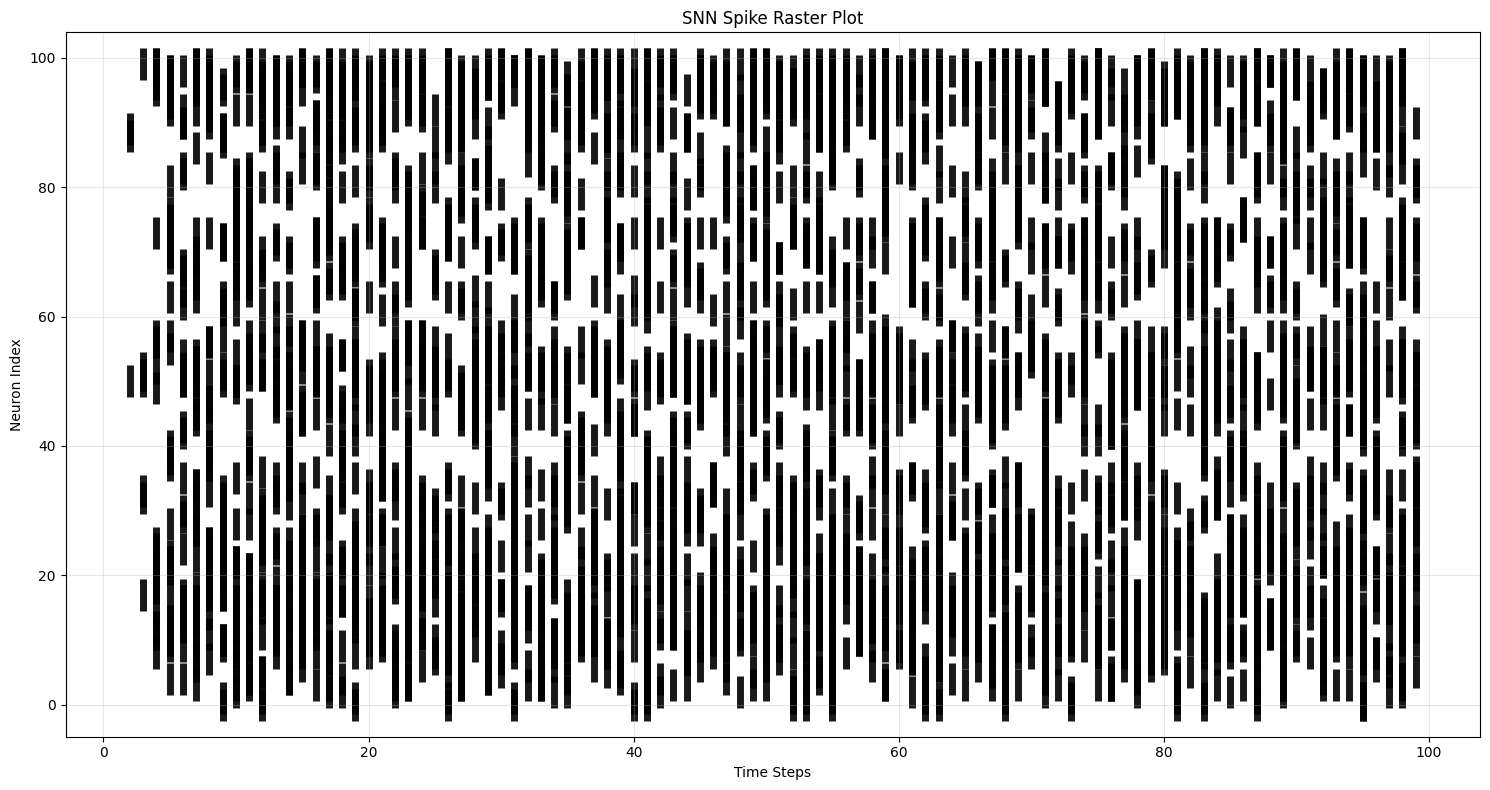

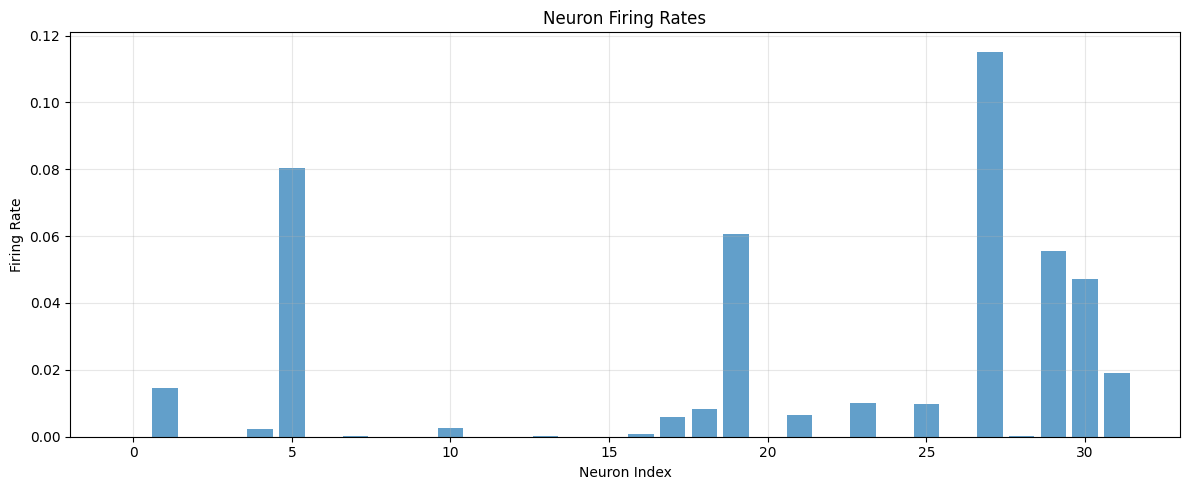


=== All Done ===


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

# snnTorch imports
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import utils
import snntorch.spikegen as spikegen
import os

# ======================
# Dataset Class
# ======================
device = None

class EMGDataset(Dataset):
    """EMG 데이터셋 클래스"""
    def __init__(self, X, y, transform=None):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)
        self.transform = transform
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        sample = self.X[idx]
        label = self.y[idx]
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample, label

# ======================
# TCN Components
# ======================

class TemporalBlock(nn.Module):
    """TCN의 기본 빌딩 블록"""
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        
        self.conv1 = nn.Conv1d(n_inputs, n_outputs, kernel_size,
                              stride=stride, padding=padding, dilation=dilation)
        self.bn1 = nn.BatchNorm1d(n_outputs)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
        
        self.conv2 = nn.Conv1d(n_outputs, n_outputs, kernel_size,
                              stride=stride, padding=padding, dilation=dilation)
        self.bn2 = nn.BatchNorm1d(n_outputs)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        
        # Residual connection
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        
    def forward(self, x):
        residual = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.dropout1(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        
        if self.downsample is not None:
            residual = self.downsample(x)

        if out.shape != residual.shape:
            min_len = min(out.shape[2], residual.shape[2])
            out = out[:, :, :min_len]
            residual = residual[:, :, :min_len] 
            
        out += residual
        return self.relu(out)

class TemporalConvNet(nn.Module):
    """Temporal Convolutional Network"""
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            
            # Causal padding
            padding = (kernel_size - 1) * dilation_size
            
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, 
                                   stride=1, dilation=dilation_size, 
                                   padding=padding, dropout=dropout)]
        
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        # x shape: (batch_size, seq_len, features) -> (batch_size, features, seq_len)
        x = x.transpose(1, 2)
        out = self.network(x)
        # Back to (batch_size, seq_len, features)
        return out.transpose(1, 2)

# ======================
# SNN Components using snnTorch
# ======================

class SpikeEncoder(nn.Module):
    """연속 신호를 스파이크로 변환하는 인코더"""
    def __init__(self, encoding_type='rate', num_steps=100):
        super(SpikeEncoder, self).__init__()
        self.encoding_type = encoding_type
        self.num_steps = num_steps
        
    def forward(self, x):
        # x shape: (batch_size, seq_len, features)
        batch_size, seq_len, features = x.shape
        
        if self.encoding_type == 'rate':
            # Rate encoding: 입력 크기에 비례하는 스파이크 확률
            # 입력을 0-1 범위로 정규화
            x_norm = torch.sigmoid(x)
            # Poisson spike generation
            spikes = spikegen.rate(x_norm, num_steps=seq_len)
            return spikes
        
        elif self.encoding_type == 'latency':
            # Latency encoding
            spikes = spikegen.latency(x, num_steps=seq_len, normalize=True, linear=True)
            return spikes
        
        else:  # 'delta'
            # Delta modulation
            spikes = spikegen.delta(x, threshold=0.1)
            spikes = spikes.repeat(seq_len, 1, 1, 1) 
            return spikes

class SNNBlock(nn.Module):
    """SNN 블록 (LIF 뉴런 사용)"""
    def __init__(self, input_size, hidden_size, num_steps=100, beta=0.9, threshold=1.0):
        super(SNNBlock, self).__init__()
        
        self.num_steps = num_steps
        self.hidden_size = hidden_size
        
        # Linear layer
        self.fc = nn.Linear(input_size, hidden_size)
        
        # LIF neuron
        self.lif = snn.Leaky(beta=beta, threshold=threshold, 
                            spike_grad=surrogate.fast_sigmoid())
        
    def forward(self, x):
        # x shape: (num_steps, batch_size, input_size)
        batch_size = x.shape[1]
        
        # Initialize hidden states
        mem = self.lif.init_leaky()
        
        spk_rec = []
        mem_rec = []
        
        for step in range(self.num_steps):
            cur = self.fc(x[step])
            spk, mem = self.lif(cur, mem)
            spk_rec.append(spk)
            mem_rec.append(mem)
            
        return torch.stack(spk_rec, dim=0), torch.stack(mem_rec, dim=0)

class SpikingNeuralNetwork(nn.Module):
    """Multi-layer SNN"""
    def __init__(self, input_size, hidden_sizes, num_steps=100, beta=0.9, threshold=1.0, encoding_type='rate'):
        super(SpikingNeuralNetwork, self).__init__()
        
        self.num_steps = num_steps
        self.layers = nn.ModuleList()
        
        # Input encoding
        self.encoder = SpikeEncoder(encoding_type=encoding_type, num_steps=num_steps)
        
        # SNN layers
        layer_sizes = [input_size] + hidden_sizes
        for i in range(len(hidden_sizes)):
            self.layers.append(
                SNNBlock(layer_sizes[i], layer_sizes[i+1], 
                        num_steps=num_steps, beta=beta, threshold=threshold)
            )
    
    def forward(self, x):
        # Encode input to spikes
        spikes = self.encoder(x)  # (num_steps, batch_size, features)
        
        # Pass through SNN layers
        for layer in self.layers:
            spikes, _ = layer(spikes)
            
        return spikes

# ======================
# Model Architectures
# ======================

class TCNClassifier(nn.Module):
    """TCN 기반 EMG 분류기"""
    def __init__(self, input_size, num_classes, tcn_channels=[64, 128, 256], 
                 kernel_size=3, dropout=0.2):
        super(TCNClassifier, self).__init__()
        
        self.tcn = TemporalConvNet(input_size, tcn_channels, kernel_size, dropout)
        
        # Attention mechanism
        self.attention = nn.MultiheadAttention(tcn_channels[-1], num_heads=8, batch_first=True)
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(tcn_channels[-1], 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.BatchNorm1d(128),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout/2),
            nn.Linear(64, num_classes)
        )
        
    def forward(self, x):
        # TCN feature extraction
        tcn_out = self.tcn(x)  # (batch_size, seq_len, features)
        
        # Self-attention
        attn_out, _ = self.attention(tcn_out, tcn_out, tcn_out)
        
        # Global average pooling
        pooled = torch.mean(attn_out, dim=1)  # (batch_size, features)
        
        # Classification
        output = self.classifier(pooled)
        return output

class SNNClassifier(nn.Module):
    """SNN 기반 EMG 분류기"""
    def __init__(self, input_size, num_classes, hidden_sizes=[128, 64], 
                 num_steps=100, beta=0.9, threshold=1.0, encoding_type='rate'):
        super(SNNClassifier, self).__init__()
        
        self.num_steps = num_steps
        self.snn = SpikingNeuralNetwork(input_size, hidden_sizes, 
                                       num_steps=num_steps, beta=beta, threshold=threshold, encoding_type=encoding_type)
      
        # Output layer
        self.output_layer = nn.Linear(hidden_sizes[-1], num_classes)
        
    def forward(self, x):
        batch_size, seq_len, features = x.shape
        
        # Get spike outputs from SNN
        spikes = self.snn(x)  # (num_steps, batch_size, hidden_size)
        
        # Convert spikes to rates (average over time)
        spike_rates = torch.mean(spikes, dim=0)  # (batch_size, hidden_size)
        
        # Classification
        output = self.output_layer(spike_rates)
        output = torch.mean(output, dim=1)
        return output

class HybridTCNSNN(nn.Module):
    """TCN과 SNN을 결합한 하이브리드 모델"""
    def __init__(self, input_size, num_classes, tcn_channels=[32, 64], 
                 snn_hidden_sizes=[64, 32], num_steps=100, kernel_size=3, dropout=0.2, encoding_type='rate', beta=0.9):
        super(HybridTCNSNN, self).__init__()
        
        self.num_steps = num_steps
        
        # TCN branch
        self.tcn = TemporalConvNet(input_size, tcn_channels, kernel_size, dropout)
        
        # SNN branch
        self.snn = SpikingNeuralNetwork(input_size, snn_hidden_sizes, num_steps, encoding_type=encoding_type)
        
        # Feature fusion
        combined_size = tcn_channels[-1] + snn_hidden_sizes[-1]
        self.fusion = nn.Sequential(
            nn.Linear(combined_size, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.BatchNorm1d(128),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout/2),
            nn.Linear(64, num_classes)
        )
        
    def forward(self, x):
        # TCN branch
        tcn_out = self.tcn(x)
        tcn_pooled = torch.mean(tcn_out, dim=1)  # Global average pooling
        
        # SNN branch
        snn_spikes = self.snn(x)
        snn_rates = torch.mean(snn_spikes, dim=0)  # Convert to rates

        snn_rates = torch.mean(snn_rates, dim=1)
        
        # Combine features
        combined = torch.cat([tcn_pooled, snn_rates], dim=1)
        
        # Final classification
        output = self.fusion(combined)
        return output

# ======================
# Data Loading Functions
# ======================

def load_ninapro_data(file_path):
    """NinaPro 데이터를 로드하고 전처리하는 함수"""
    try:
        # .mat 파일 로드
        data = sio.loadmat(file_path)
        
        print("Available keys in the data:", list(data.keys()))
        
        # EMG 데이터 추출
        if 'emg' in data:
            emg_data = data['emg']
        elif 'data' in data:
            emg_data = data['data']
        else:
            data_keys = [k for k in data.keys() if not k.startswith('__')]
            emg_data = data[data_keys[0]]
        
        # 라벨 데이터 추출
        if 'stimulus' in data:
            labels = data['stimulus'].flatten()
        elif 'restimulus' in data:
            labels = data['restimulus'].flatten()
        elif 'glove' in data:
            labels = data['glove']
            if labels.ndim > 1:
                labels = labels[:, 0]
        else:
            label_keys = [k for k in data.keys() if 'stimulus' in k.lower() or 'label' in k.lower()]
            if label_keys:
                labels = data[label_keys[0]].flatten()
            else:
                data_keys = [k for k in data.keys() if not k.startswith('__')]
                labels = data[data_keys[1]].flatten() if len(data_keys) > 1 else np.zeros(emg_data.shape[0])
        
        print(f"EMG data shape: {emg_data.shape}")
        print(f"Labels shape: {labels.shape}")
        print(f"Unique labels: {np.unique(labels)}")
        
        return emg_data, labels
    
    except Exception as e:
        print(f"Error loading data: {e}")
        print("Generating sample data for demonstration...")
        
        # 샘플 데이터 생성
        n_samples = 10000
        n_channels = 12
        emg_data = np.random.randn(n_samples, n_channels) * 0.1
        
        # EMG 신호처럼 보이도록 시간적 상관관계 추가
        for i in range(n_channels):
            emg_data[:, i] += np.sin(np.linspace(0, 100*np.pi, n_samples) + i) * 0.05
            emg_data[:, i] += np.convolve(np.random.randn(n_samples), 
                                        np.ones(5)/5, mode='same') * 0.02
        
        labels = np.random.randint(0, 7, n_samples)  # 0-6 클래스
        return emg_data, labels

def preprocess_data_for_networks(emg_data, labels, window_size=200, overlap=100):
    """네트워크를 위한 EMG 데이터 전처리"""
    # 레이블이 0인 rest 구간 제거 (선택사항)
    non_zero_mask = labels != 0
    emg_data = emg_data[non_zero_mask]
    labels = labels[non_zero_mask]
    
    # 윈도우 기반 시퀀스 생성
    windowed_sequences = []
    windowed_labels = []
    
    step_size = window_size - overlap
    
    for i in range(0, len(emg_data) - window_size + 1, step_size):
        window = emg_data[i:i+window_size]
        window_label = labels[i:i+window_size]
        
        # 윈도우 내에서 가장 빈번한 라벨 사용
        unique_labels, counts = np.unique(window_label, return_counts=True)
        dominant_label = unique_labels[np.argmax(counts)]
        
        windowed_sequences.append(window)
        windowed_labels.append(dominant_label)
    
    return np.array(windowed_sequences), np.array(windowed_labels)

# ======================
# Training Functions
# ======================

def train_model(model, train_loader, val_loader, num_epochs=1, lr=0.001):
    """모델 훈련 함수"""
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, verbose=True)
    
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    best_val_acc = 0.0
    patience_counter = 0
    patience = 20
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()
        
        train_acc = 100 * train_correct / train_total
        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_acc)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                
                val_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                val_total += target.size(0)
                val_correct += (predicted == target).sum().item()
        
        val_acc = 100 * val_correct / val_total
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_acc)
        
        # Learning rate scheduling
        scheduler.step(val_acc)
        
        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            # Save best model
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_acc:.2f}%, '
                  f'Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_acc:.2f}%')
    
    # Load best model
    model.load_state_dict(torch.load('best_model.pth'))
    
    history = {
        'train_loss': train_losses,
        'train_acc': train_accuracies,
        'val_loss': val_losses,
        'val_acc': val_accuracies
    }
    
    return model, history

def evaluate_model(model, test_loader):
    """모델 평가 함수"""
    model.eval()
    test_correct = 0
    test_total = 0
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            
            test_total += target.size(0)
            test_correct += (predicted == target).sum().item()
            
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    test_acc = 100 * test_correct / test_total
    return test_acc, np.array(all_predictions), np.array(all_targets)

# ======================
# Visualization Functions
# ======================

def plot_training_history(histories, model_names):
    """훈련 과정 시각화"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    colors = ['blue', 'red', 'green', 'orange', 'purple']
    
    for i, (history, name) in enumerate(zip(histories, model_names)):
        color = colors[i % len(colors)]
        
        # Training accuracy
        axes[0, 0].plot(history['train_acc'], label=f'{name}', 
                       color=color, linewidth=2)
        
        # Validation accuracy
        axes[0, 1].plot(history['val_acc'], label=f'{name}', 
                       color=color, linewidth=2)
        
        # Training loss
        axes[1, 0].plot(history['train_loss'], label=f'{name}', 
                       color=color, linewidth=2)
        
        # Validation loss
        axes[1, 1].plot(history['val_loss'], label=f'{name}', 
                       color=color, linewidth=2)
    
    axes[0, 0].set_title('Training Accuracy', fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy (%)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    axes[0, 1].set_title('Validation Accuracy', fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy (%)')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    axes[1, 0].set_title('Training Loss', fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    axes[1, 1].set_title('Validation Loss', fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.suptitle('Model Training Comparison', fontsize=16, fontweight='bold')
    plt.tight_layout()
    count_path = os.path.join("../output/delta", "model_trainint_delta.png")
    plt.savefig(count_path)
    plt.close(fig)

def plot_confusion_matrix(y_true, y_pred, class_names, model_name):
    """혼동 행렬 시각화"""
    cm = confusion_matrix(y_true, y_pred)
    
    fig = plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{model_name} - Confusion Matrix', fontsize=16, fontweight='bold')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    count_path = os.path.join("../output/delta", "rasterplot_delta.png")
    plt.savefig(count_path)
    plt.close(fig)

def visualize_snn_spikes(model, sample_data, num_steps=100, num_neurons=100):
    """SNN 스파이크 시각화"""
    if not hasattr(model, 'snn'):
        print("Model doesn't have SNN component")
        return
    
    model.eval()
    with torch.no_grad():
        sample_data = sample_data.to(device)
        
        # Get spikes from SNN
        if hasattr(model, 'snn'):
            spikes = model.snn(sample_data[:1])  # First sample only
        else:
            # For pure SNN model
            spikes = model.snn(sample_data[:1])
        
        # spikes shape: (num_steps, 1, hidden_size)
        spike_data = spikes.squeeze(1).cpu().numpy()  # (num_steps, hidden_size)
       

        # spike_data: (T, N) 혹은 (B, T, N) 라고 가정 (마지막 축이 뉴런 축)
        arr = np.asarray(spike_data)
        
        if arr.ndim == 3:        # (B, T, N)
            firing_rates = spike_data.mean(axis=(0, 1)) if spike_data.shape[-1] == spike_data.shape[-1] else spike_data.mean(axis=(0, 1))
        elif arr.ndim == 2:      # (T, N)
            firing_rates = arr.mean(axis=0)       # -> (N,)
        else:
            raise ValueError(f"Unexpected spike_data shape: {arr.shape}")
        
        fig = plt.figure(figsize=(15, 8))
        
        # Raster plot
        for neuron_idx in range(min(num_neurons, spike_data.shape[1])):
            spike_times = np.where(spike_data[:, neuron_idx] > 0.5)[0]
            plt.scatter(spike_times, [neuron_idx] * len(spike_times), 
                       marker='|', s=500, alpha=0.9, linewidths=5, color='black')
        
        plt.xlabel('Time Steps')
        plt.ylabel('Neuron Index')
        plt.title('SNN Spike Raster Plot')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        count_path = os.path.join("../output/delta", "snn_delta_raster.png")
        plt.savefig(count_path)
        plt.show()
        plt.close(fig)
      
        
        # Firing rate histogram
    
        fig = plt.figure(figsize=(12, 5))
        plt.bar(range(len(firing_rates)), firing_rates, alpha=0.7)
        plt.xlabel('Neuron Index')
        plt.ylabel('Firing Rate')
        plt.title('Neuron Firing Rates')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        count_path = os.path.join("../output/delta", "neuron_firing_delta.png")
        plt.savefig(count_path)
        plt.show()
        plt.close(fig)

def plot_model_comparison_results(results):
    """모델 성능 비교 결과 시각화"""
    model_names = list(results.keys())
    accuracies = [results[name]['test_acc'] for name in model_names]
    
    fig = plt.figure(figsize=(10, 6))
    bars = plt.bar(model_names, accuracies, alpha=0.7, 
                   color=['blue', 'red', 'green', 'orange'])
    
    # Add value labels on bars
    for bar, acc in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{acc:.2f}%', ha='center', va='bottom', fontweight='bold')
    
    plt.ylabel('Test Accuracy (%)')
    plt.title('Model Performance Comparison', fontsize=16, fontweight='bold')
    plt.ylim(0, 100)
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    count_path = os.path.join("../output/delta", "model_performance_com_delta.png")
    plt.savefig(count_path)
    plt.close(fig)


# ======================
# Main Function
# ======================
def main():
    # Check if CUDA is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # 데이터 경로 설정
    DATA_PATH = "../../data/DB6/DB6_s1_a/S1_D1_T1.mat"
    encoding_type = 'delta'
    print("=== EMG Classification with TCN and SNN using PyTorch ===")
    
    # 1. 데이터 로드
    print("\n1. Loading data...")
    emg_data, labels = load_ninapro_data(DATA_PATH)
    
    # 2. 데이터 전처리
    print("\n2. Preprocessing data...")
    X, y = preprocess_data_for_networks(emg_data, labels, window_size=200, overlap=100)
    
    print(f"Sequence data shape: {X.shape}")
    print(f"Labels shape: {y.shape}")
    print(f"Number of classes: {len(np.unique(y))}")
    
    # 3. 라벨 인코딩
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    num_classes = len(np.unique(y_encoded))
    class_names = [f"Gesture {i}" for i in range(num_classes)]
    
    # 4. 데이터 분할
    print("\n3. Splitting data...")
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y_encoded, test_size=0.15, random_state=42, stratify=y_encoded
    )
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp
    )
    
    print(f"Train set: {X_train.shape[0]} samples")
    print(f"Validation set: {X_val.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")
    
    # 5. 데이터 정규화
    print("\n4. Normalizing data...")
    scaler = StandardScaler()

    # 2D로 변형 후 스케일링, 다시 3D로 복원
    X_train_res = X_train.reshape(-1, X_train.shape[-1])
    X_val_res = X_val.reshape(-1, X_val.shape[-1])
    X_test_res = X_test.reshape(-1, X_test.shape[-1])

    X_train_scaled = scaler.fit_transform(X_train_res).reshape(X_train.shape)
    X_val_scaled = scaler.transform(X_val_res).reshape(X_val.shape)
    X_test_scaled = scaler.transform(X_test_res).reshape(X_test.shape)

    # 6. DataLoader 생성
    print("\n5. Creating DataLoaders...")
    train_dataset = EMGDataset(X_train_scaled, y_train)
    val_dataset = EMGDataset(X_val_scaled, y_val)
    test_dataset = EMGDataset(X_test_scaled, y_test)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # 7. 모델 학습 및 평가
    print("\n6. Training Models...")
    results = {}
    histories = []


    # Hybrid
    print("\n--- Training Hybrid TCN-SNN Model ---")
    hybrid_model = HybridTCNSNN(input_size=X_train.shape[-1], num_classes=num_classes, encoding_type=encoding_type)
    hybrid_model, hybrid_history = train_model(hybrid_model, train_loader, val_loader)
    hybrid_test_acc, hybrid_preds, hybrid_targets = evaluate_model(hybrid_model, test_loader)



    # 10. SNN Spike 시각화
    print("\n10. Visualizing Spikes (Hybrid Model)...")
    sample_input = torch.FloatTensor(X_test_scaled[:1])
    visualize_snn_spikes(hybrid_model, sample_input)

    print("\n=== All Done ===")
    return hybrid_model, hybrid_history, scaler, label_encoder

if __name__ == "__main__":
    model, history, scaler, label_encoder = main()
